In [9]:
import glob
import os

def get_images(input_folder):
    images = sorted(glob.glob(os.path.join(input_folder, '**', '*.jpg'), recursive=True))
    if not images:
        raise ValueError(f'No images found in {input_folder}')
    return images

def get_labels(input_folder):
    labels = sorted(glob.glob(os.path.join(input_folder, '**', '*.txt'), recursive=True))
    if not labels:
        raise ValueError(f'No labels found in {input_folder}')
    return labels

def get_files(input_folder='./'):
    images = get_images(input_folder)
    labels = get_labels(input_folder)

    if len(images) != len(labels):
        raise ValueError(f'Number of images ({len(images)}) and labels ({len(labels)}) do not match')
    if len(images) == 0:
        raise ValueError(f'No images found in {input_folder}')

    return images, labels

input_folder = '/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@gmail.com/My Drive/Dev-Drive/Competitions/Competitions-2024/M10-BKAI-Object_Detection/BKAI_Hackathon_2024-Track1/data/raw/train_20241023/'
def main():
    images, labels = get_files(input_folder)
    print(f'Found {len(images)} images and labels')
    print(f'Images: {images[:5]}')
    print(f'Labels: {labels[:5]}')

if __name__ == '__main__':
    main()

Found 11521 images and labels
Images: ['/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@gmail.com/My Drive/Dev-Drive/Competitions/Competitions-2024/M10-BKAI-Object_Detection/BKAI_Hackathon_2024-Track1/data/raw/train_20241023/daytime/cam_01_00001.jpg', '/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@gmail.com/My Drive/Dev-Drive/Competitions/Competitions-2024/M10-BKAI-Object_Detection/BKAI_Hackathon_2024-Track1/data/raw/train_20241023/daytime/cam_01_00002.jpg', '/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@gmail.com/My Drive/Dev-Drive/Competitions/Competitions-2024/M10-BKAI-Object_Detection/BKAI_Hackathon_2024-Track1/data/raw/train_20241023/daytime/cam_01_00003.jpg', '/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@gmail.com/My Drive/Dev-Drive/Competitions/Competitions-2024/M10-BKAI-Object_Detection/BKAI_Hackathon_2024-Track1/data/raw/train_20241023/daytime/cam_01_00004.jpg', '/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@

In [10]:
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import glob

# Đường dẫn đến thư mục dữ liệu
input_folder = '/Users/phatvu/Library/CloudStorage/GoogleDrive-phatvu.coder@gmail.com/My Drive/Dev-Drive/Competitions/Competitions-2024/M10-BKAI-Object_Detection/BKAI_Hackathon_2024-Track1/data/raw/train_20241023/'

# Lấy danh sách tất cả các tệp ảnh và annotation
image_files = sorted(glob.glob(os.path.join(input_folder, '**', '*.jpg'), recursive=True))
label_files = sorted(glob.glob(os.path.join(input_folder, '**', '*.txt'), recursive=True))

# Xây dựng danh sách các lớp cho mỗi ảnh
image_labels = []
all_classes = set()

for label_file in label_files:
    label_path = label_file
    classes_in_image = set()
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) > 0:
                    class_id = parts[0]
                    classes_in_image.add(class_id)
    image_labels.append(list(classes_in_image))
    all_classes.update(classes_in_image)

all_classes = sorted(list(all_classes))
print(f'Tổng số lớp: {len(all_classes)}')

# Sử dụng MultiLabelBinarizer để chuyển đổi danh sách lớp thành ma trận binary
mlb = MultiLabelBinarizer(classes=all_classes)
Y = mlb.fit_transform(image_labels)

print(f'Dimension of Y: {Y.shape}')  # (num_samples, num_classes)


Tổng số lớp: 8
Dimension of Y: (11521, 8)


In [11]:
# Tỷ lệ phân chia
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Sử dụng MultilabelStratifiedShuffleSplit để chia train và temp (val + test)
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=(val_size + test_size), random_state=42)
train_idx, temp_idx = next(msss1.split(image_files, Y))

# Tỷ lệ của validation và test trong temp
test_ratio = test_size / (val_size + test_size)

# Chia temp thành validation và test
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)
val_idx, test_idx = next(msss2.split(np.array(image_files)[temp_idx], Y[temp_idx]))

# Lấy danh sách các file cho mỗi tập
train_files = [image_files[i] for i in train_idx]
val_files = [image_files[i] for i in temp_idx[val_idx]]
test_files = [image_files[i] for i in temp_idx[test_idx]]

print(f'Số lượng ảnh - Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}')


Số lượng ảnh - Train: 8057, Validation: 2312, Test: 1152


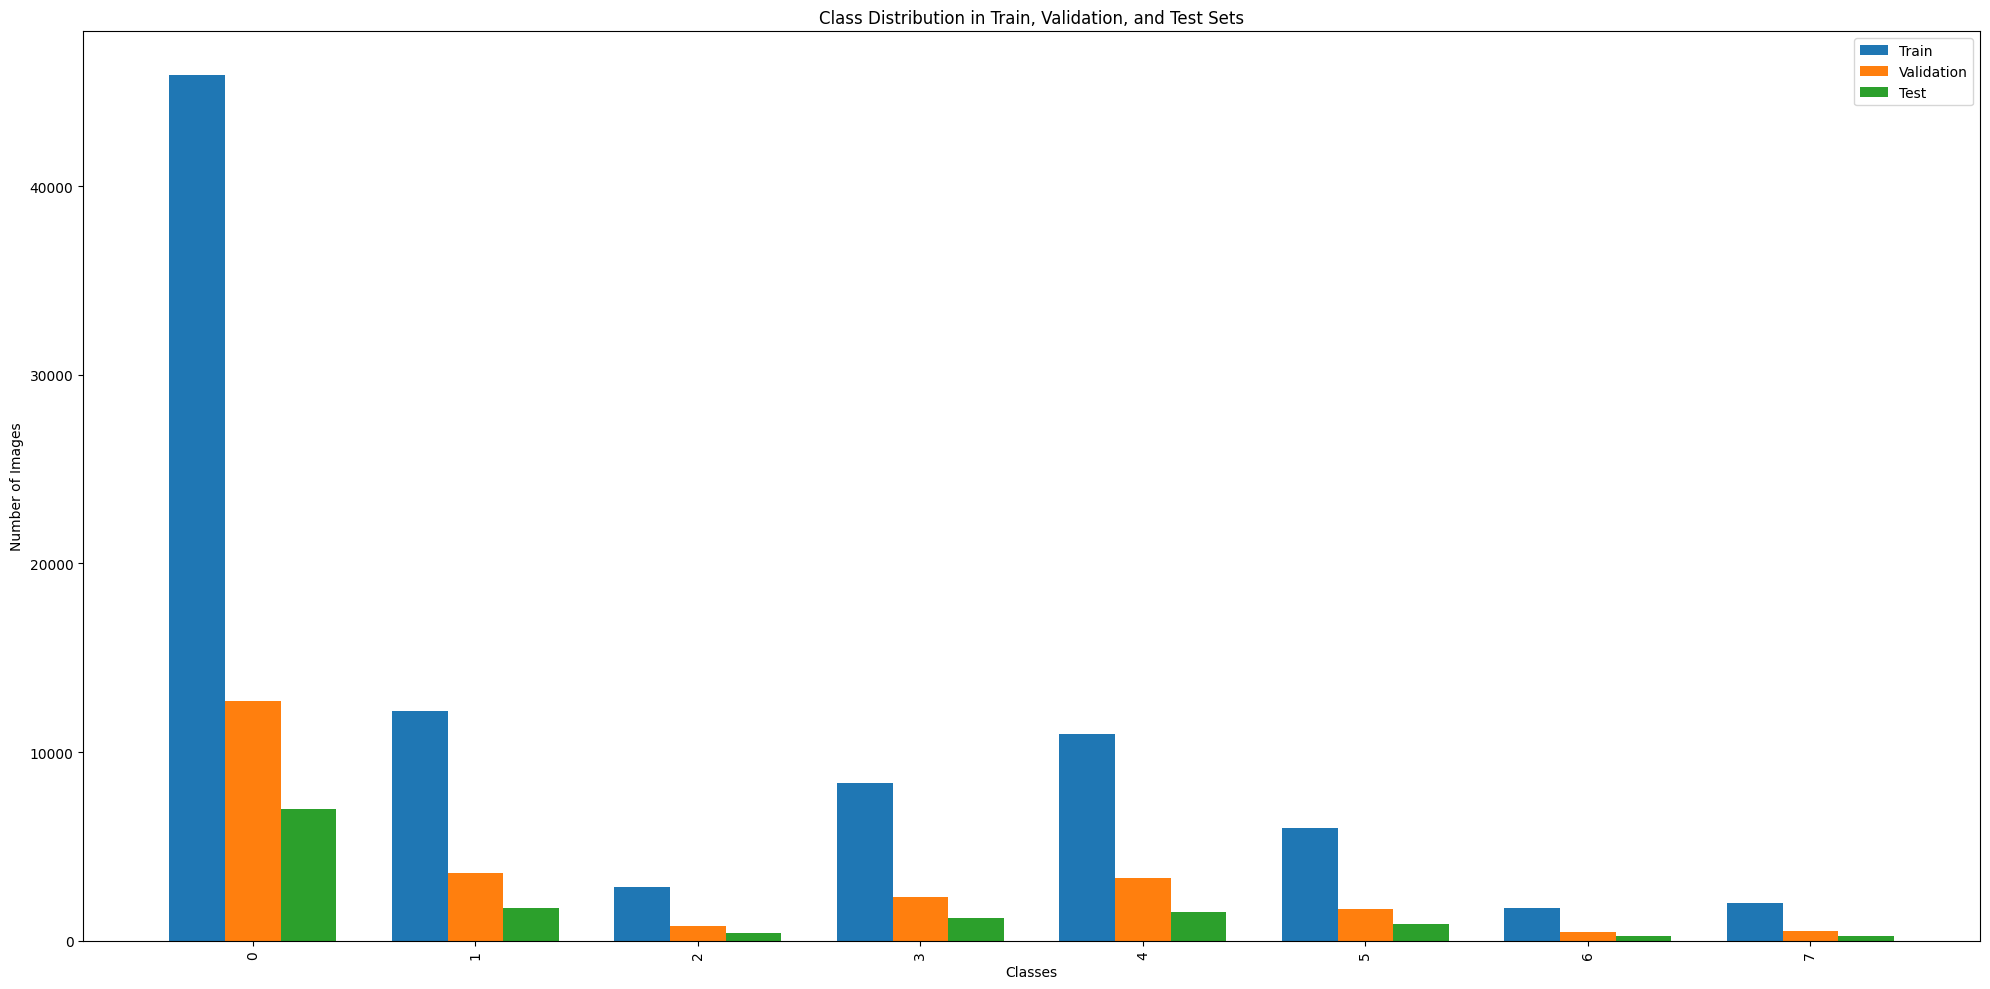

In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt

def get_class_distribution(file_list, labels_dir, all_classes):
    class_count = defaultdict(int)
    for file in file_list:
        label_path = os.path.join(labels_dir, file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 0:
                        class_id = parts[0]
                        class_count[class_id] += 1
    distribution = [class_count.get(cls, 0) for cls in all_classes]
    return distribution

train_dist = get_class_distribution(train_files, os.path.join(input_folder, "labels"), all_classes)
val_dist = get_class_distribution(val_files, os.path.join(input_folder, "labels"), all_classes)
test_dist = get_class_distribution(test_files, os.path.join(input_folder, "labels"), all_classes)

# Vẽ biểu đồ phân bố lớp
x = np.arange(len(all_classes))
width = 0.25

plt.figure(figsize=(20, 10))
plt.bar(x - width, train_dist, width, label='Train')
plt.bar(x, val_dist, width, label='Validation')
plt.bar(x + width, test_dist, width, label='Test')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xticks(x, all_classes, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
def save_split(file_list, split_name, output_dir='splits'):
    os.makedirs(output_dir, exist_ok=True)
    split_path = os.path.join(output_dir, f'{split_name}.txt')
    with open(split_path, 'w') as f:
        for file in file_list:
            f.write(os.path.join('images', file) + '\n')
    print(f'Lưu {split_name} tại {split_path}')

save_split(train_files, 'train')
save_split(val_files, 'val')
save_split(test_files, 'test')


Lưu train tại splits/train.txt
Lưu val tại splits/val.txt
Lưu test tại splits/test.txt


In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# Định nghĩa các phép augment
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.Resize(width=640, height=640),
    ToTensorV2(),
])

def augment_image(image_path):
    image = np.array(Image.open(image_path))
    augmented = transform(image=image)
    return augmented['image']

# Áp dụng augment cho các ảnh chứa các lớp ít xuất hiện
# Bạn cần xác định các lớp ít xuất hiện và áp dụng augment cho các ảnh chứa chúng
